In [2]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import os # 解决库冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [42]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [43]:
class KaggleHouse(d2l.DataModule): # 用于加载和缓存数据集
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download( #一个自定义用于下载文件的函数
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [44]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [45]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [46]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self): # 这部分是在进行预处理
    
    # Remove the ID and label columns
    label = 'SalePrice' # 这里是目标变量的标签
    features = pd.concat( # 合并两个数据集
        (self.raw_train.drop(columns=['Id', label]), # 去除训练集里面的 Id 标签列
         self.raw_val.drop(columns=['Id']))) # 去除验证集中的 Id 标签列
    
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    # features.dtypes != 'object' 这部分筛选出不是 object 类型的列，也就是选择数值型列。
    # .index 获取索引号
    features[numeric_features] = features[numeric_features].apply(
        # .apply(...)：对选中的数值特征列应用一个自定义的函数。
        lambda x: (x - x.mean()) / (x.std()))
        # lambda 匿名函数，稀奇
    
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # fillna 是 pandas 的一个方法，用于将数据框或系列（Series）中的缺失值填充为指定的值。
    
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # pd.get_dummies 是 pandas 库中的一个函数，用于将分类变量（例如字符串或分类数据）转换为独热编码格式（one-hot encoding）。
    
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    # self.raw_train.shape[0] 表示 self.raw_train 的行数。
    # [:self.raw_train.shape[0]] 表示从第 0 行到 self.raw_train.shape[0] - 1 行的切片。
    # .copy() 方法拷贝一个副本
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [47]:
data.preprocess()
data.train.shape

(1460, 331)

In [48]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [49]:
def k_fold_data(data, k): # 交叉验证折数 k
    rets = [] # 用于存储每一折的训练集和验证集
    fold_size = data.train.shape[0] // k # 计算每一折的大小
    for j in range(k): # 遍历 k 次，每次处理一折数据
        idx = range(j * fold_size, (j+1) * fold_size)
        # 计算当前折的索引范围。第j折的索引从 j * fold_size 开始，到 (j+1) * fold_size 结束
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))
        # 将当前折的数据添加到 rets 列表中。
        # data.train.drop(index=idx): 将当前折的索引 idx 以外的数据作为训练集。
        # data.train.loc[idx]: 将当前折的数据作为验证集
    return rets

In [50]:
def k_fold(trainer, data, k, lr): # 训练模型，并计算平均验证误差
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)): # 为每一折生成一个模型
        model = d2l.LinearRegression(lr)
        model.board.yscale='log' # 设置损失的y轴为对数刻度，便于观察变化
        if i != 0: model.board.display = False # 从第二次迭代开始，不显示模型的训练过程。
        trainer.fit(model, data_fold) # 使用当前折的数据 data_fold 训练模型
        val_loss.append(float(model.board.data['val_loss'][-1].y)) # 将验证损失的最后一个值（即验证集上的损失）添加到 val_loss 列表中
        models.append(model) # 将当前模型添加到 models 列表中
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

C:\Users\elaim\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\elaim\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\elaim\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
C:\Users\elaim\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature und

average validation log mse = 0.1777593919634819


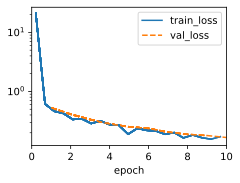

In [51]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [52]:
# 生成一个 csv 文件将结果上传到 Kaggle
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

"""Exercise
1. 效果一般
2. 不一定是好主意。如果缺失值不是随机的，而是依赖于其他变量或特定模式（如在收入较高的人群中缺少某些消费数据），用均值填补可能会引入偏差。
3. 略
4. 增加模型的复杂性可以让它更好地拟合数据。可以尝试增加神经网络的层数、调整层的神经元数量、加入权重衰减（L2正则化）和dropout层以防止过拟合，来提升模型的泛化性能。
6. 如果不标准化，特征值的范围差异会导致模型在训练时难以收敛，特别是在使用梯度下降时。特征值较大的变量可能会主导损失函数，影响模型的训练效果。标准化可以让模型更快速、稳定地优化，提高模型的性能。
"""